In [184]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
#from scipy.integrate import odeint
import mplcyberpunk
import tqdm
#from functions import nth_derivative

In [185]:
plt.style.use('cyberpunk')
#mplcyberpunk.make_lines_glow()

In [186]:
def nth_derivative(net, x:torch.Tensor, j:int, i:int ,n:int) -> torch.Tensor:
    """
    Esta función está creada para regresar la n-derivada de la componente j de la
    función ann respecto de la variable i. 
    
    ann(x)=(ann_0(x), ann_1(x)...,ann_j(x)...).
    
    Con x=(x_0,x_1,...,x_i,...)
    
    x debe ser un tensor: torch.Size([n, m])

    Para el buen funcionamiento: net(x)[0].shape = torch.Size([1])
    """
    x.requires_grad=True
    # Initialize the gradient tensor to 1.0, as the 0th derivative is the function itself.
    ann=net(x)[:,j].view(-1,1)
    grad_tensor = torch.ones(ann.size(), dtype=torch.float32, requires_grad=True)
    for _ in range(n):
        Dann=torch.autograd.grad(ann, x, grad_outputs=grad_tensor, create_graph=True)[0][:,i]
        Dann=Dann.reshape(ann.shape)
        ann=Dann
    return ann

In [245]:
# Definición de la función F(t)
def F(t):
  """
  Función vectorial F(t) = (t^2, 2t).

  Args:
    t: Tensor de PyTorch que representa el tiempo.

  Returns:
    Tensor de PyTorch que representa la función F(t).
  """
  t_squared = torch.pow(t, 2)
  two_t = 2 * t
  return torch.stack((t_squared, two_t), dim=1)

# Ejemplo de uso
t = torch.linspace(0.0, 1.0, 100)
f_t = F(t)

In [250]:
F(torch.tensor([3]))

tensor([[9, 6]])

In [256]:
nth_derivative(F,torch.tensor([[3.0]]), 1, 0,1)

tensor([[2.]], grad_fn=<ViewBackward0>)

Lets solve the ODE system:

\begin{align} 
x' =& 2x + y \\
y' =& -x + 3y
\end{align}

with $x(0) = 1$, $y(0) = 2$

\begin{align} 
x(t) =& \frac{1}{3}e^t + \frac{2}{3}e^{4t} \\
y(t) =& \frac{1}{3}e^t + \frac{2}{3}e^{4t}
\end{align}

## System of Ordinary Differential Equations
A number of coupled differential equations form a system of equations. Let $t \in \mathcal{R}$ 
be the independent variable and $$\bar{x}(t) : \mathcal{R}\longrightarrow \mathcal{R}^m$$
be a function of $t$. A system of ordinary differential equations of order $n$ takes the form:

$$F(t, \vec{x}, \frac{d\vec{x}}{dt}, \frac{d^2\vec{x}}{dt^2}, \ldots, \frac{d^n\vec{x}}{dt^n}) = \vec{0},
$$

\\


\\


$$
\begin{split}\begin{pmatrix}
f_0(t, \vec{x}, \displaystyle\frac{d\vec{x}}{dt}, \displaystyle\frac{d^2\vec{x}}{dt^2}, \ldots, \displaystyle\frac{d^n\vec{x}}{dt^n}) \\
f_1(t, \vec{x}, \displaystyle\frac{d\vec{x}}{dt}, \displaystyle\frac{d^2\vec{x}}{dt^2}, \ldots, \displaystyle\frac{d^n\vec{x}}{dt^n}) \\
\vdots \\
f_{m-1}(t, \vec{x}, \displaystyle\frac{d\vec{x}}{dt}, \displaystyle\frac{d^2\vec{x}}{dt^2}, \ldots, \displaystyle\frac{d^n\vec{x}}{dt^n})
\end{pmatrix}
=
\begin{pmatrix}
0 \\
0 \\
\vdots \\
0
\end{pmatrix}\end{split}
$$

In [289]:
nodos=35
ANN = nn.Sequential(nn.Linear(1, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(),nn.Linear(nodos,2))
print(ANN)

Sequential(
  (0): Linear(in_features=1, out_features=35, bias=True)
  (1): Tanh()
  (2): Linear(in_features=35, out_features=35, bias=True)
  (3): Tanh()
  (4): Linear(in_features=35, out_features=2, bias=True)
)


In [260]:
#The domain and the batch for the training
ti=0.0
tf=10.0

t=torch.linspace(ti,tf,30).view(-1,1)

In [214]:
t.shape

torch.Size([30, 1])

In [215]:
nth_derivative(ANN,t, 0, 0,2)

tensor([[-0.0186],
        [-0.0386],
        [-0.0457],
        [-0.0306],
        [-0.0189],
        [-0.0237],
        [-0.0337],
        [-0.0383],
        [-0.0366],
        [-0.0313],
        [-0.0246],
        [-0.0181],
        [-0.0123],
        [-0.0075],
        [-0.0037],
        [-0.0007],
        [ 0.0014],
        [ 0.0029],
        [ 0.0039],
        [ 0.0045],
        [ 0.0048],
        [ 0.0049],
        [ 0.0048],
        [ 0.0046],
        [ 0.0044],
        [ 0.0040],
        [ 0.0037],
        [ 0.0034],
        [ 0.0030],
        [ 0.0027]], grad_fn=<ViewBackward0>)

In [315]:
#reparam of the solution to meet the initial conditions
init_conditions=torch.tensor([[1.5,1.0]])

def Param(t,x0=init_conditions,net=ANN):
    #out = net(T)
    #b=1-torch.exp(ti-T[:,0])
    #return torch.reshape(T[:,1],out.size()) + b*out
    #return T[:,1].view(-1,1) + a.view(-1,1) +b.view(-1,1)**2 * out
    return x0 + (1.0-torch.exp(ti-t))*net(t)
    #return x0 + b.view(-1,1) * out

In [313]:
ANN(t)[1]*(1-torch.exp(ti-t))[1]

tensor([-0.0001,  0.0002], grad_fn=<MulBackward0>)

In [316]:
ANN(init_conditions)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 1x35)

In [242]:
1-torch.exp(ti-t)

tensor([[0.0000],
        [0.2917],
        [0.4983],
        [0.6446],
        [0.7482],
        [0.8217],
        [0.8737],
        [0.9105],
        [0.9366],
        [0.9551],
        [0.9682],
        [0.9775],
        [0.9840],
        [0.9887],
        [0.9920],
        [0.9943],
        [0.9960],
        [0.9972],
        [0.9980],
        [0.9986],
        [0.9990],
        [0.9993],
        [0.9995],
        [0.9996],
        [0.9997],
        [0.9998],
        [0.9999],
        [0.9999],
        [0.9999],
        [1.0000]], grad_fn=<RsubBackward1>)

In [240]:
(1-torch.exp(ti-t))*ANN(t)

tensor([[-0.0000e+00,  0.0000e+00],
        [-7.8359e-02,  1.5176e-01],
        [-2.0956e-01,  2.5065e-01],
        [-3.4861e-01,  2.9938e-01],
        [-4.6528e-01,  3.0382e-01],
        [-5.4814e-01,  2.7494e-01],
        [-5.9889e-01,  2.2619e-01],
        [-6.2475e-01,  1.6999e-01],
        [-6.3360e-01,  1.1542e-01],
        [-6.3178e-01,  6.7811e-02],
        [-6.2378e-01,  2.9327e-02],
        [-6.1250e-01,  7.1487e-05],
        [-5.9972e-01, -2.0962e-02],
        [-5.8648e-01, -3.5206e-02],
        [-5.7337e-01, -4.4120e-02],
        [-5.6074e-01, -4.9002e-02],
        [-5.4875e-01, -5.0925e-02],
        [-5.3750e-01, -5.0733e-02],
        [-5.2700e-01, -4.9076e-02],
        [-5.1727e-01, -4.6441e-02],
        [-5.0828e-01, -4.3187e-02],
        [-5.0000e-01, -3.9576e-02],
        [-4.9239e-01, -3.5799e-02],
        [-4.8542e-01, -3.1989e-02],
        [-4.7904e-01, -2.8240e-02],
        [-4.7321e-01, -2.4615e-02],
        [-4.6790e-01, -2.1154e-02],
        [-4.6306e-01, -1.788

In [227]:
Param(t)

tensor([[1.5000, 1.0000],
        [1.4216, 1.1518],
        [1.2904, 1.2507],
        [1.1514, 1.2994],
        [1.0347, 1.3038],
        [0.9519, 1.2749],
        [0.9011, 1.2262],
        [0.8752, 1.1700],
        [0.8664, 1.1154],
        [0.8682, 1.0678],
        [0.8762, 1.0293],
        [0.8875, 1.0001],
        [0.9003, 0.9790],
        [0.9135, 0.9648],
        [0.9266, 0.9559],
        [0.9393, 0.9510],
        [0.9512, 0.9491],
        [0.9625, 0.9493],
        [0.9730, 0.9509],
        [0.9827, 0.9536],
        [0.9917, 0.9568],
        [1.0000, 0.9604],
        [1.0076, 0.9642],
        [1.0146, 0.9680],
        [1.0210, 0.9718],
        [1.0268, 0.9754],
        [1.0321, 0.9788],
        [1.0369, 0.9821],
        [1.0413, 0.9852],
        [1.0454, 0.9880]], grad_fn=<AddBackward0>)

In [218]:
nth_derivative(Param,t, 0, 0,2)

tensor([[ 0.0558],
        [-0.0125],
        [-0.0558],
        [-0.0628],
        [-0.0549],
        [-0.0548],
        [-0.0594],
        [-0.0598],
        [-0.0543],
        [-0.0453],
        [-0.0355],
        [-0.0263],
        [-0.0184],
        [-0.0119],
        [-0.0068],
        [-0.0029],
        [-0.0001],
        [ 0.0018],
        [ 0.0032],
        [ 0.0040],
        [ 0.0045],
        [ 0.0046],
        [ 0.0046],
        [ 0.0045],
        [ 0.0043],
        [ 0.0040],
        [ 0.0037],
        [ 0.0033],
        [ 0.0030],
        [ 0.0027]], grad_fn=<ViewBackward0>)

\begin{align} 
x' =& 2x + y \\
y' =& -x + 3y
\end{align}

In [219]:
nth_derivative(Param,t, 0, 0,1) - Param(t)[:,0].view(-1,1)

tensor([[-1.3270],
        [-1.3816],
        [-1.4546],
        [-1.5300],
        [-1.5970],
        [-1.6557],
        [-1.7089],
        [-1.7561],
        [-1.7954],
        [-1.8257],
        [-1.8473],
        [-1.8613],
        [-1.8693],
        [-1.8725],
        [-1.8724],
        [-1.8699],
        [-1.8659],
        [-1.8610],
        [-1.8558],
        [-1.8506],
        [-1.8456],
        [-1.8411],
        [-1.8371],
        [-1.8337],
        [-1.8308],
        [-1.8286],
        [-1.8269],
        [-1.8258],
        [-1.8252],
        [-1.8251]], grad_fn=<SubBackward0>)

In [344]:
# def cost(t):
#     x=Param(t)[:,0].view(-1,1)
#     y=Param(t)[:,1].view(-1,1)
#     Dt_x = nth_derivative(Param,t, 0, 0,1)
#     Dt_y = nth_derivative(Param,t, 1, 0,1)
    
#     #x0=ANN(torch.tensor([[0.0]]))+torch.tensor([[1.5,1.0]])

#     return torch.linalg.norm(Dt_x - x + x*y)**2 + torch.linalg.norm(Dt_y - x*y +y)**2 #+ torch.linalg.norm(x0)**2

def cost(t):
    x=ANN(t)[:,0].view(-1,1)
    y=ANN(t)[:,1].view(-1,1)
    Dt_x = nth_derivative(ANN,t, 0, 0,1)
    Dt_y = nth_derivative(ANN,t, 1, 0,1)
    x0=ANN(torch.tensor([0])-torch.zeros_like(t))
    return torch.linalg.norm(Dt_x - x - x*y)**2 + torch.linalg.norm(Dt_y - x*y -y)**2 + torch.linalg.norm(ANN(torch.tensor([0.0]))-init_conditions)


In [345]:
ANN(torch.tensor([0.0]))-init_conditions


tensor([[-1.2834, -0.7833]], grad_fn=<SubBackward0>)

In [346]:
x=ANN(t)[:,0].view(-1,1)
y=ANN(t)[:,1].view(-1,1)
Dt_x = nth_derivative(ANN,t, 0, 0,1)
Dt_y = nth_derivative(ANN,t, 1, 0,1)
#x0=ANN(torch.tensor([[0.0]]))+torch.tensor([[1.5,1.0]])




In [347]:
Dt_x - x - x*y

tensor([[-3.7485e-01],
        [-3.2638e-01],
        [-2.6810e-01],
        [-2.0716e-01],
        [-1.5127e-01],
        [-1.0539e-01],
        [-7.0801e-02],
        [-4.6293e-02],
        [-2.9654e-02],
        [-1.8684e-02],
        [-1.1594e-02],
        [-7.0776e-03],
        [-4.2337e-03],
        [-2.4629e-03],
        [-1.3747e-03],
        [-7.1794e-04],
        [-3.3275e-04],
        [-1.1764e-04],
        [-8.3772e-06],
        [ 3.5415e-05],
        [ 3.9260e-05],
        [ 1.9174e-05],
        [-1.4825e-05],
        [-5.6428e-05],
        [-1.0172e-04],
        [-1.4827e-04],
        [-1.9456e-04],
        [-2.3980e-04],
        [-2.8337e-04],
        [-3.2502e-04]], grad_fn=<SubBackward0>)

In [348]:
torch.linalg.norm(ANN(torch.tensor([[0.0]]))-torch.tensor([[1.5,1.0]]))

tensor(1.5035, grad_fn=<LinalgVectorNormBackward0>)

In [349]:
cost(t)

tensor(2.3125, grad_fn=<AddBackward0>)

In [350]:
learning_rate=0.01
epocas=300

optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate, weight_decay=0.1)


Training: 100%|███████████████████████████████████████| 300/300 [00:02<00:00, 138.50it/s, loss=1.77]


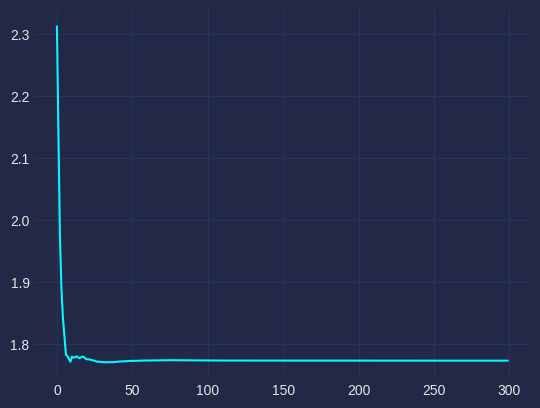

In [351]:
#loop de entrenamiendo 
pbar = tqdm.tqdm(range(epocas), desc="Training",  colour='cyan', ncols=100)

errores=[]
for i in pbar:
    l=cost(t) #coste
    #l=torch.nn.MSELoss(Param(T))
    l.backward() #gradiente
    optimizer.step() #se actualizan los parámetros
    optimizer.zero_grad() #vacíamos el gradiente
    #print('época=%.2f , loss=%.2f'%(i,l))
    errores.append(float(l))
    #tqdm.set_description('época: %d , loss: %.2f' % (i, l.item()))
    pbar.set_postfix({'loss': l.item()})
    #pbar.set_refresh(50)
    #tqdm.set_description("Training")
    #print('época=%.2f , loss=%.2f'%(i,l))

plt.plot(range(epocas),errores)

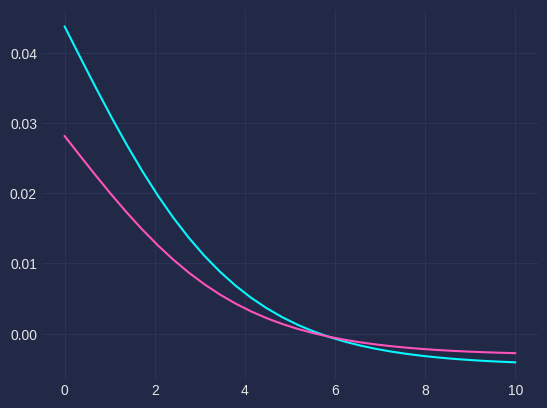

In [353]:
plt.plot(t.detach(),ANN(t).detach()[:,0])
plt.plot(t.detach(),ANN(t).detach()[:,1])

#plt.plot(t.detach(),1/3 * torch.exp(t.detach()) + 2/3*torch.exp(4.0*t.detach()))
         
#y(t) =& \frac{1}{3}e^t + \frac{2}{3}e^{4t})

In [340]:
Param(torch.tensor([0.0]))

tensor([[1.5000, 1.0000]], grad_fn=<AddBackward0>)

In [108]:
torch.linalg.norm(ANN(torch.tensor([0.0]))-torch.tensor([[1.5,1.0]]))**2

tensor(3.2931, grad_fn=<PowBackward0>)

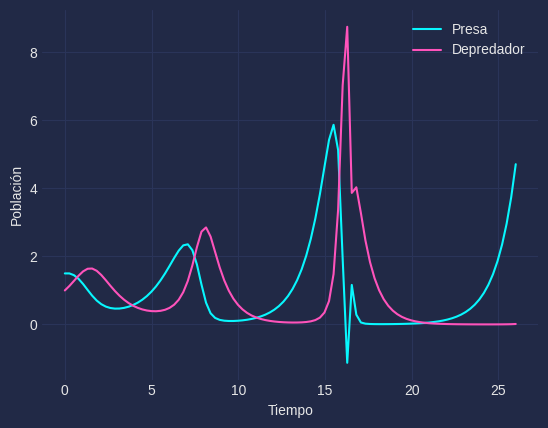

In [211]:
# Parámetros del modelo
a = 1.0
b = 1.0
c = 1.0
d = 1.0

# Ecuaciones de Lotka-Volterra
def dxdt(x, y):
  return a * x - b * x * y

def dydt(x, y):
  return c * x * y - d * y

# Solución numérica de las ecuaciones
t = np.linspace(0,26, 100)
x = np.zeros(len(t))
y = np.zeros(len(t))

x[0] = 1.5
y[0] = 1.0

for i in range(1, len(t)):
  x[i] = x[i - 1] + dxdt(x[i - 1], y[i - 1]) * (t[i] - t[i - 1])
  y[i] = y[i - 1] + dydt(x[i - 1], y[i - 1]) * (t[i] - t[i - 1])

# Gráfica de las poblaciones
plt.plot(t, x, label="Presa")
plt.plot(t, y, label="Depredador")
plt.xlabel("Tiempo")
plt.ylabel("Población")
plt.legend()
plt.show()